<a href="https://colab.research.google.com/github/Muhammad-junaid-mujtaba/laama-3.2-finetuning/blob/main/Copy_of_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
<hr>

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

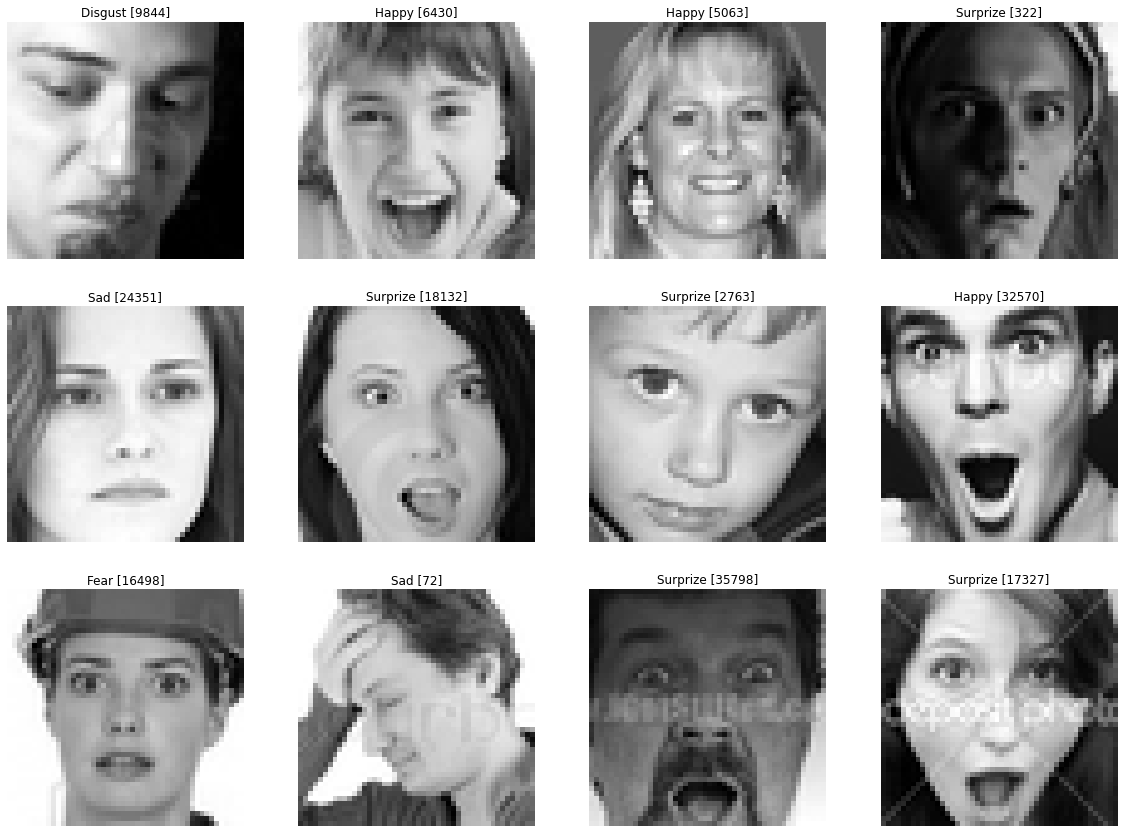

##Here we are also going to use OpenCV for the webcam and model deployement.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


**Put the name of the dataset that you want to use and then unzip the dataset**

In [ ]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.csv             

#Importing necesaary files
<hr>



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [ ]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (32441, 3))

#Exploraotry Data Analysis
<hr>



In [ ]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 1
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32441 entries, 0 to 32440
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  32441 non-null  int64 
 1   pixels   32441 non-null  object
 2   Usage    32440 non-null  object
dtypes: int64(1), object(2)
memory usage: 760.5+ KB


,emotion
count,32441.000000
mean,3.322586
std,1.873604
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [ ]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4484,Angry
1,493,Disgust
2,4608,Fear
3,8148,Happy
4,5505,Sad
5,3603,Surprize
6,5600,Neutral


##No of images present in dataset corresponding to training testing and validation part

In [ ]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,142
PublicTest,3589
Training,28709


##Visualizing images from the dataset

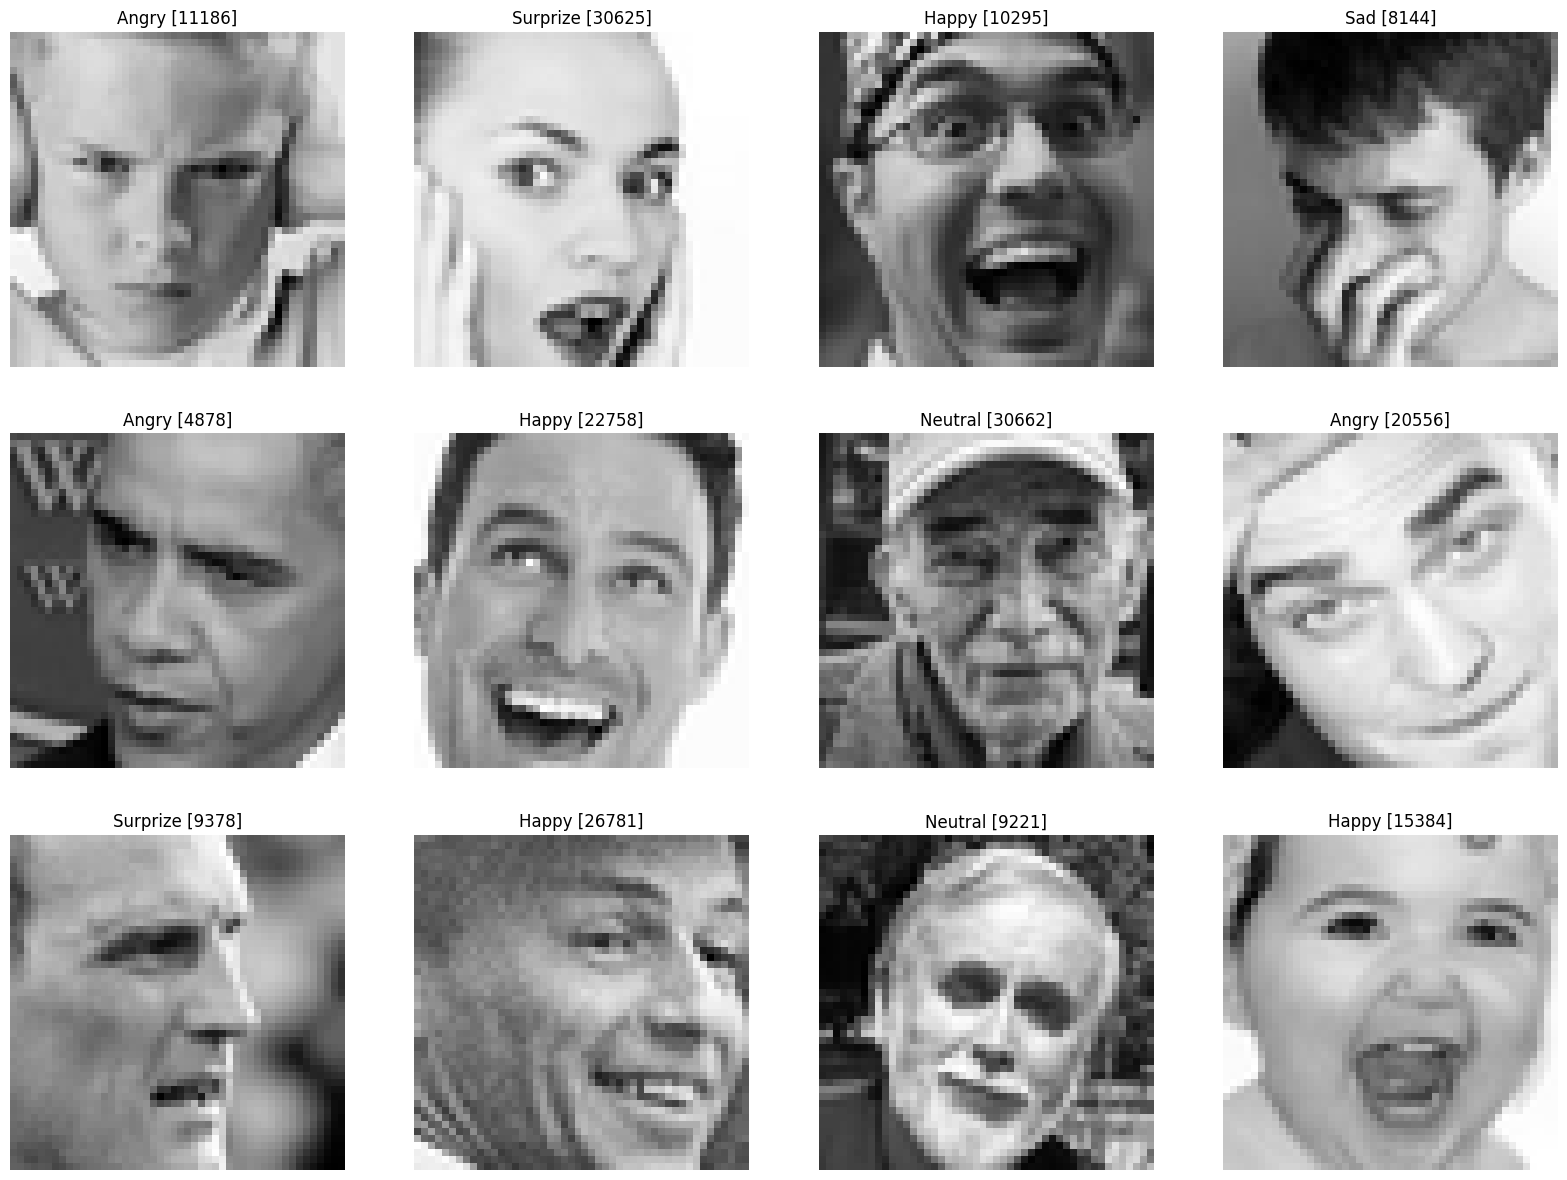

In [ ]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [ ]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (142, 2304), (142,), (3589, 2304), (3589,))

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

In [ ]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (142, 48, 48, 1),
 (142, 7),
 (3589, 48, 48, 1),
 (3589, 7))

#Defining Model Archietechture

VGG16

In [ ]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [ ]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)          │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l1 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pad2 (ZeroPadding2D)          │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l2 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad1 (ZeroPadding2D)          │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l1 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l2 (ZeroPadding2D)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad2 (Conv2D)                 │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad1 (ZeroPadding2D)          │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l1 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad2 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l2 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad3 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l3 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad1 (ZeroPadding2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l1 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad2 (ZeroPadding2D)          │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l2 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for early stopping and model checkpointing
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode='max', patience=10),
    ModelCheckpoint('facialemotionmodel.keras', monitor='val_accuracy', verbose=1,
                    save_best_only=True, mode='max')  # Save the best weights
]

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks=checkpointer,
    validation_data=(X_val, y_val)
)

# Save model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture and weights saved successfully.")


Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9754 - loss: 0.0806
Epoch 1: val_accuracy improved from -inf to 0.57035, saving model to facialemotionmodel.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.9754 - loss: 0.0806 - val_accuracy: 0.5704 - val_loss: 2.5083
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9732 - loss: 0.0844
Epoch 2: val_accuracy improved from 0.57035 to 0.58373, saving model to facialemotionmodel.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.9732 - loss: 0.0844 - val_accuracy: 0.5837 - val_loss: 2.4299
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9790 - loss: 0.0678
Epoch 3: val_accuracy improved from 0.58373 to 0.59348, saving model to facialemotionmodel.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.9790 - loss: 0.0679 - val_accuracy: 0.5935 - val_loss: 2.4841
Epoch 4/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9797 - loss: 0.0637
Epoch 4

#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

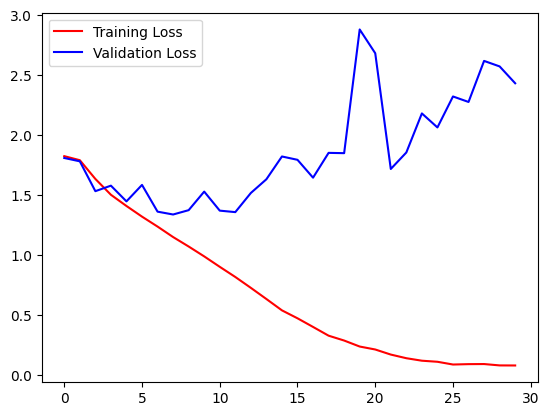

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [ ]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step


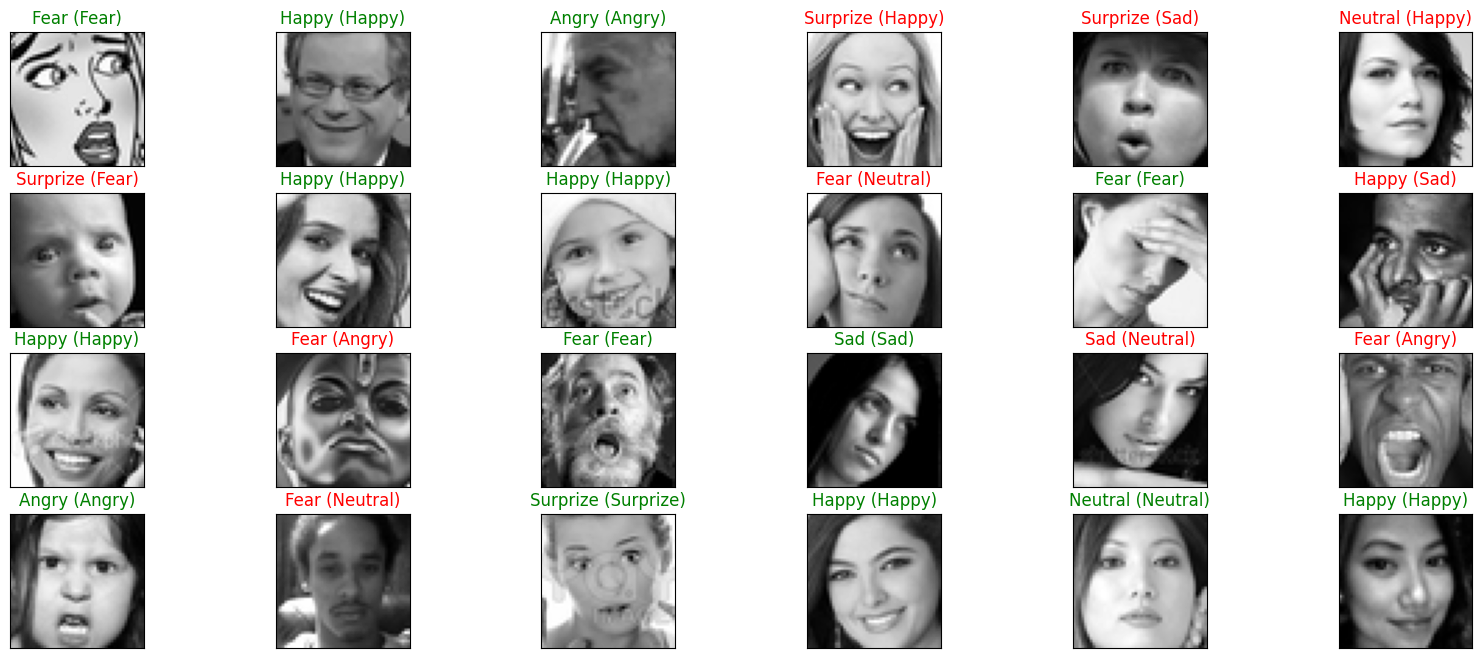

In [ ]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]

      ax.set_title("{} ({})".format((predict_index),
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [ ]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

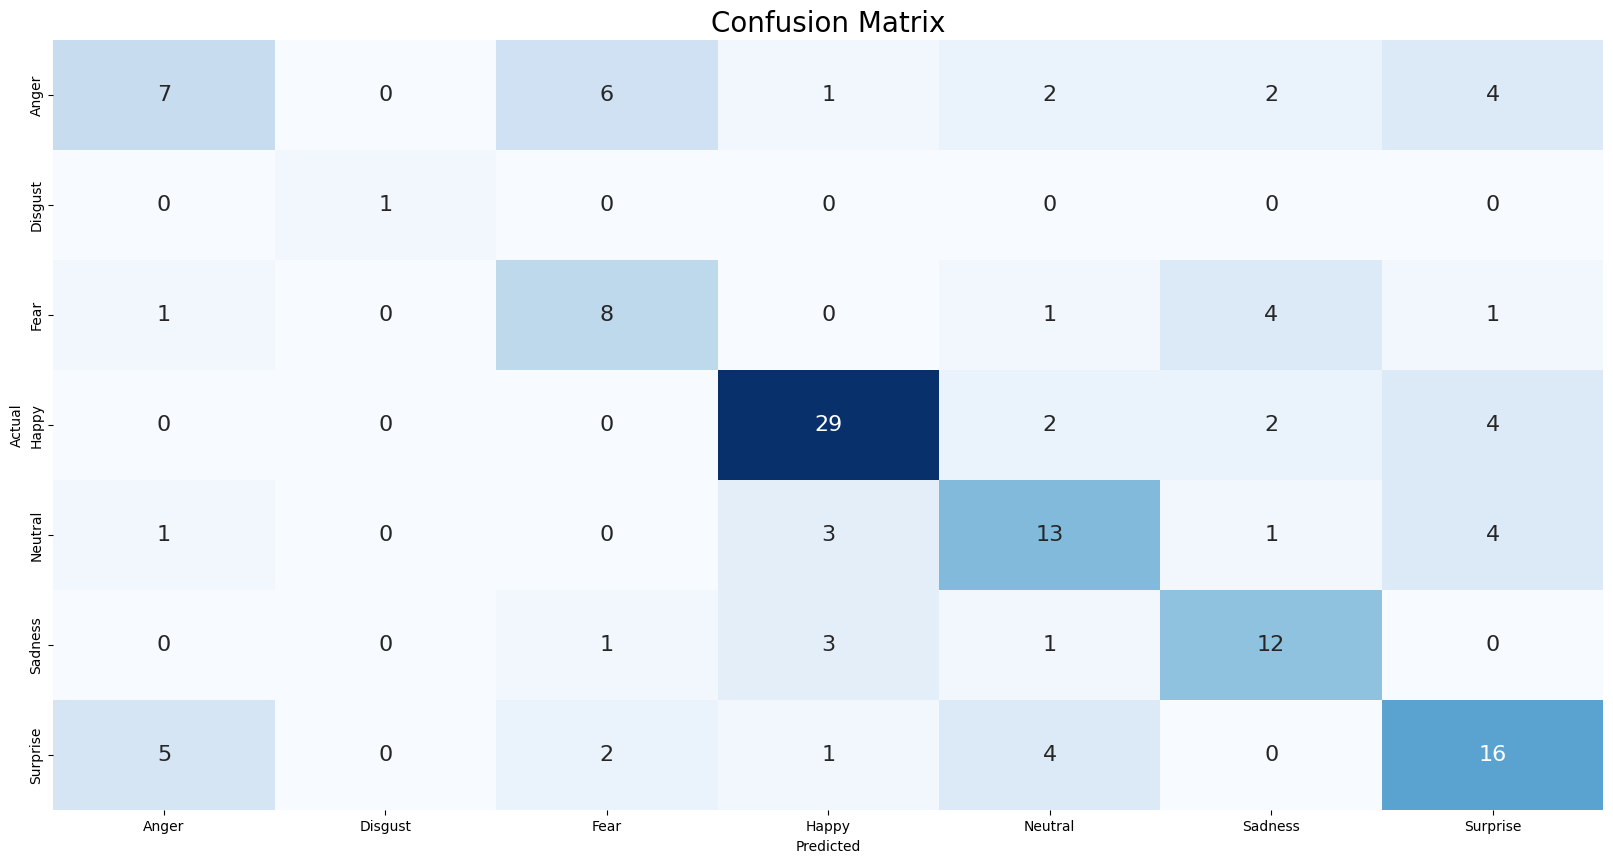

In [ ]:
conf_mat(y_test,y_pred)

In [ ]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.500     0.318     0.389        22
           1      1.000     1.000     1.000         1
           2      0.471     0.533     0.500        15
           3      0.784     0.784     0.784        37
           4      0.565     0.591     0.578        22
           5      0.571     0.706     0.632        17
           6      0.552     0.571     0.561        28

    accuracy                          0.606       142
   macro avg      0.635     0.643     0.635       142
weighted avg      0.603     0.606     0.600       142



In [ ]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9794 - loss: 0.0648
On Training Data [0.07009664177894592, 0.9781253337860107]
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5929 - loss: 2.3552
On Validation Data [2.321763038635254, 0.5904151797294617]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5665 - loss: 2.2837
On Test Data [2.126171588897705, 0.6056337952613831]


#Fine Tuning
<hr>

Let's try to improve the model

##1. Changing epoch, learning rate and batch size

##2. Changing optimizer

#Observation

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#Model Saving

#Deploying model using OpenCV
<hr>

Note: Run the below code in your local machine

##loading model arch and weights

In [ ]:
# Save the entire model to a single file
model.save("facialemotionmodel.keras")


In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model("facialemotionmodel.keras")
try:
    model = load_model("facialemotionmodel.keras")
except Exception as e:
    print(f"Error loading model: {e}")


In [ ]:
import os
print("Current working directory:", os.getcwd())
# Create the 'models' directory if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")
    print("Directory 'models' created.")
else:
    print("Directory 'models' already exists.")


Current working directory: /content
Directory 'models' already exists.


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# remove the comment from the following line to save model weights
model.save_weights("facialemotionmodel.json")
print("Saved model to disk")

ValueError: The filename must end in `.weights.h5`. Received: filepath=facialemotionmodel.json

##Open CV code for webcam and prediction

In [ ]:
import cv2
cap=cv2.VideoCapture(0) # start webcam
model="/content/facialemotionmodel.h5"

while True:
    (valid,test_image)=cap.read() #reading image from video frame
    if not valid: #if not getting frames then exit
        break

    gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


    faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
    for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches



        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index

        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]


        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
    #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)


        resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
        cv2.imshow('Emotion Dectector',resize_image)
        if cv2.waitKey(10) == ord('b'):
            break
cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

In [ ]:
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class CustomSequential(Sequential):
    pass


In [ ]:
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class CustomSequential(Sequential):
    pass

#... later in your code ...
json_file = open("facialemotionmodel.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json, custom_objects={'Sequential': CustomSequential})  # Pass custom_objects
model.load_weights("facialemotionmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


OSError: Unable to synchronously open file (truncated file: eof = 33554432, sblock->base_addr = 0, stored_eof = 50865984)

In [ ]:
from tensorflow.keras.utils import load_img
import numpy as np


def ef(image):
    img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # Resize image while loading
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

In [ ]:
image = '/content/th (3).jpeg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
label = ['angry','disgust','fear','happy','neutral','sad','surprise']
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
model prediction is  sad


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
model prediction is  sad


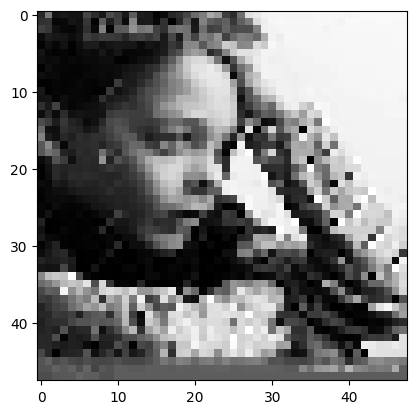

In [ ]:
image = '/content/th (2).jpeg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model # Import load_model from tensorflow.keras.models
from tensorflow.keras.utils import img_to_array # Keep img_to_array import
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# ... (rest of your code remains the same) ...

# Load the Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Specify the path to the input image
image_path = '/content/th (9).jpeg'


# Load and process the image
test_image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces_detected = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Define emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load your Keras model
model = load_model('/content/facialemotionmodel.h5') # Assuming this is your model path

# Process each detected face
for (x, y, w, h) in faces_detected:
    # Draw a rectangle around the face
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Extract the region of interest (ROI) for the face
    roi_gray = gray_image[y:y + h, x:x + w]
    roi_gray = cv2.resize(roi_gray, (48, 48))  # Resize to the input size expected by the model
    image_pixels = img_to_array(roi_gray)  # Convert image to array
    image_pixels = np.expand_dims(image_pixels, axis=0)  # Expand dims as model needs input in batches

    # Normalize the image as per the model's requirement
    image_pixels /= 255

    # Make prediction
    predictions = model.predict(image_pixels) # Now 'model' is a Keras model object
    max_index = np.argmax(predictions[0])  # Get the index of the max prediction

    # Map index to emotion
    emotion_prediction = emotion_labels[max_index]

    # Put the emotion label text on the image
    cv2.putText(test_image, emotion_prediction, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with detected faces and emotions
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()

# Print the model's prediction for reference
print("Model prediction is:", emotion_prediction)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/facialemotionmodel.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)